# 目的
- エンゼルの出現確率を購入者毎に予測する
- 独立に予測した結果と階層モデルで予測した結果を比較する

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import itertools
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm


In [2]:
sns.set()

# データの取得

In [3]:
data = pd.read_csv('angel_data_for_publish.csv')
data.head()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight,silver,gold,buyer_idx
0,2017-12-10,2018-09-01,CA9,31.103,4.776,15,0,2,1,A,26.327,1.755133,0,0,0
1,2017-12-10,2018-09-01,CA9,31.477,4.767,15,0,2,1,A,26.710,1.780667,0,0,0
2,2017-12-10,2018-09-01,CA9,31.615,4.777,15,0,2,1,A,26.838,1.789200,0,0,0
3,2017-12-10,2018-09-01,CA9,31.212,4.785,15,0,2,1,A,26.427,1.761800,0,0,0
4,2017-12-10,2018-09-01,CA9,31.394,4.819,15,0,2,1,A,26.575,1.771667,0,0,0


# エンゼル出現確率の推定

In [4]:
buyer = data['buyer'].values
buyer_idx = pd.Categorical(data['buyer']).codes
buyer_cat = pd.Categorical(data['buyer']).categories
data['buyer_idx'] = buyer_idx
lst_buyer = list(set(buyer_idx))
print(buyer_cat)
print(set(buyer_idx))

Index(['A', 'B', 'C'], dtype='object')
{0, 1, 2}


In [5]:
total_counts = data.groupby(['buyer_idx']).count()['silver'].values
angel_counts = data.query('silver > 0').groupby(['buyer_idx']).count()['silver'].values

print('total_count : {}'.format(total_counts))
print('angel_count : {}'.format(angel_counts))


total_count : [142  80  59]
angel_count : [6 5 2]


## 頻度（最尤推定）を計算

[0.04225352 0.0625     0.03389831]


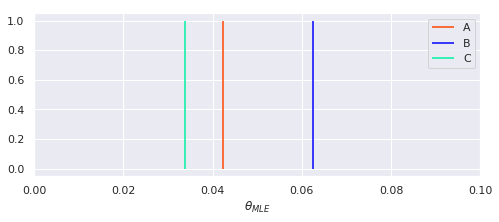

In [6]:
theta_mle = angel_counts/total_counts
print(theta_mle)

fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)
cs = ['#FF4500', '#0000FF', '#00F1A1']
for idx in np.arange(0, len(theta_mle)):
    ax.vlines(theta_mle[idx], 0, 1, colors=cs[idx%len(cs)], label=buyer_cat[idx])
ax.set_xlim((0.0, 0.1))
ax.set_xlabel('$\\theta_{MLE}$')
ax.legend()
plt.savefig('buyer_effect_mle.png')

## 購入者ごとに独立に推定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:04<00:00, 1204.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122145470>,
      dtype=object)

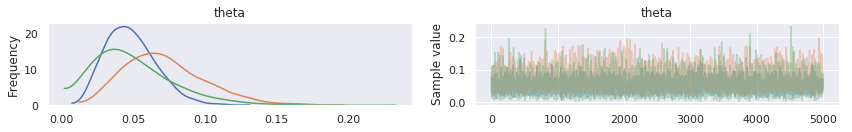

In [7]:
with pm.Model() as comparing_buyer_i:
    theta = pm.Beta('theta', alpha=1, beta=1, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])
    
    trace_iso = pm.sample(5000, chains=1, random_seed=100)
pm.traceplot(trace_iso)

In [8]:
pm.summary(trace_iso)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta__0,0.048496,0.017565,0.000257,0.018873,0.083639
theta__1,0.072249,0.028298,0.000381,0.025035,0.128825
theta__2,0.049783,0.028042,0.000319,0.004510,0.104216


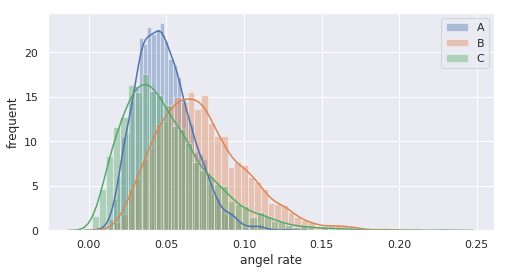

In [9]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_iso['theta'][:,i], label=buyer_cat[i], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_iso.png')

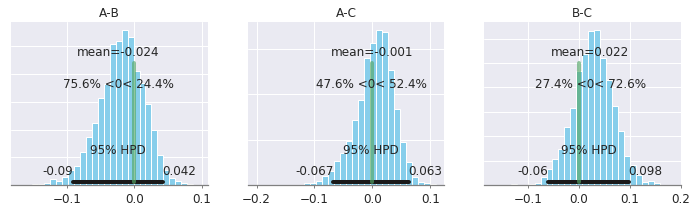

In [10]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, len(lst_buyer)), 2):
    theta_diff = trace_iso['theta'][:, i] - trace_iso['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_isomodel.png')

## 購入者の性質を加える
- 真の出現率は決まっているはず(真の確率を$p$とする)
- 購入者毎の運の要素が入ってくる（不正行為かも、独自の購入戦略があるのかも）可能性がある
  - 購入者毎の特性を個人差$u_i$とする
- エンゼルの出現は確率$\theta_i$の二項分布
- 確率$\theta_i$は以下のロジットリンク関数で線形モデルを仮定
$$
logit(\theta_i) = p + u_i
$$

- $p$、$u_i$は正規分布を事前分布とする

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [u, p, su]
Sampling 3 chains: 100%|██████████| 10500/10500 [00:09<00:00, 1063.73draws/s]
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6804802914805098, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121478400>,
      dtype=object)

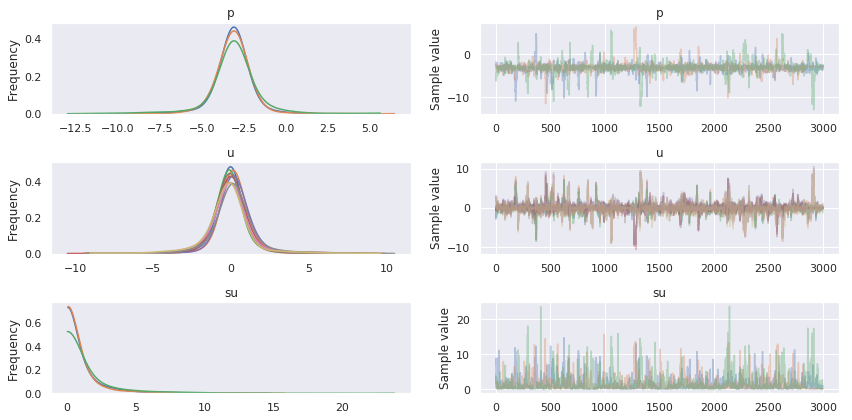

In [11]:
with pm.Model() as comparing_buyer_m1:
    su = pm.HalfNormal('su', sd=10)
    p = pm.Normal('p', mu=0, sd=10)
    u = pm.Normal('u', mu=0, sd=su, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', 
                        n=total_counts[lst_buyer], 
                        p=pm.math.sigmoid(p+u[lst_buyer]), observed=angel_counts[lst_buyer])
    
    trace_h1 = pm.sample(3000, chains=3, random_seed=100)
pm.traceplot(trace_h1)

In [12]:
pm.summary(trace_h1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,-3.128649,1.304091,0.042882,-5.986118,-0.663117,707.921332,1.000432
u__0,-0.024248,1.305570,0.042342,-2.643039,2.679621,711.853868,1.000251
u__1,0.229140,1.318751,0.042631,-2.284564,3.106614,728.124894,1.000178
u__2,-0.180927,1.326126,0.042917,-2.966489,2.574440,745.010707,1.000200
su,1.364190,1.877925,0.061578,0.072777,5.004440,813.021358,1.004340


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122045cf8>,
      dtype=object)

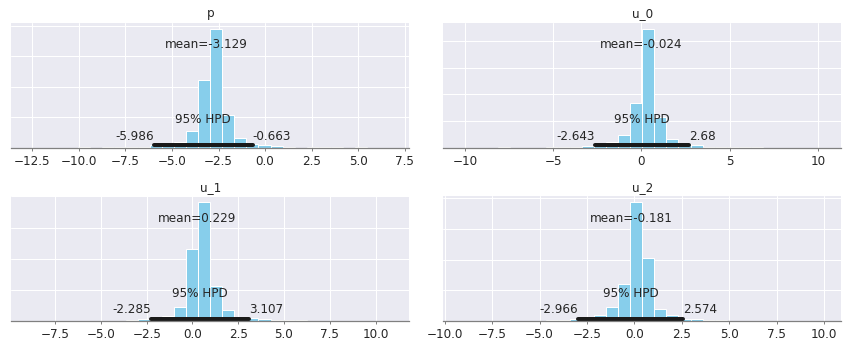

In [13]:
pm.plot_posterior(trace_h1, varnames=['p', 'u'])

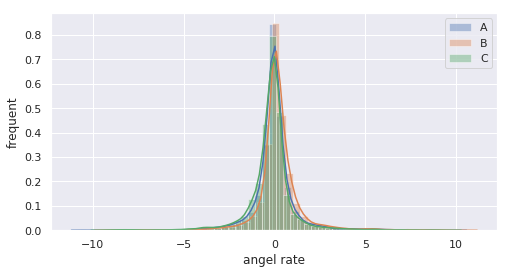

In [22]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_h1['u'][:,i], label=buyer_cat[i], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_h1model.png')

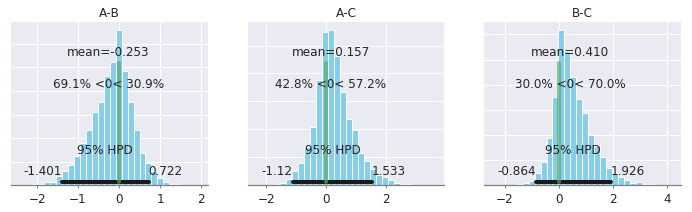

In [15]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, 3), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, 3), 2):
    u_diff = trace_h1['u'][:, i] - trace_h1['u'][:, j]
    pm.plot_posterior(u_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_h1model.png')

In [16]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [17]:
post_min = pm.summary(trace_h1).loc['p', 'hpd_2.5']
post_mean = pm.summary(trace_h1).loc['p', 'mean']
post_max = pm.summary(trace_h1).loc['p', 'hpd_97.5']
print('{} < {} < {}'.format(sigmoid(post_min), sigmoid(post_mean), sigmoid(post_max)))

0.002507101149808126 < 0.04194086171223964 < 0.34003970875103123


No handles with labels found to put in legend.


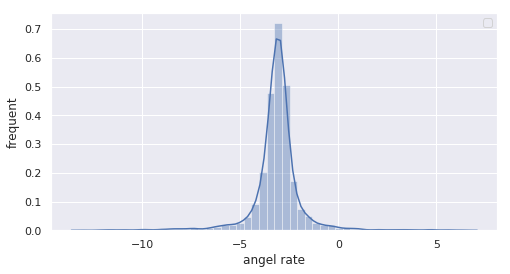

In [23]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

sns.distplot(trace_h1['p'], ax=ax)
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_h1model_tp.png')

## 階層モデルとして、全体を統括するパラメータがあると仮定
- 真の出現率を決めるパラメータがあるはず
- 購入者毎の運によって↑のパラメータに基づいたパラメータがサンプルされる
- エンゼルの出現は確率$\theta_i$の二項分布
- $\theta$の事前分布はベータ分布
- ベータ分布のパラメータに事前分布を設定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [theta, beta, alpha]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:08<00:00, 887.04draws/s]
There were 895 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29932290489251745, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.64022293501303, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1235bf6d8>,
      dtype=object)

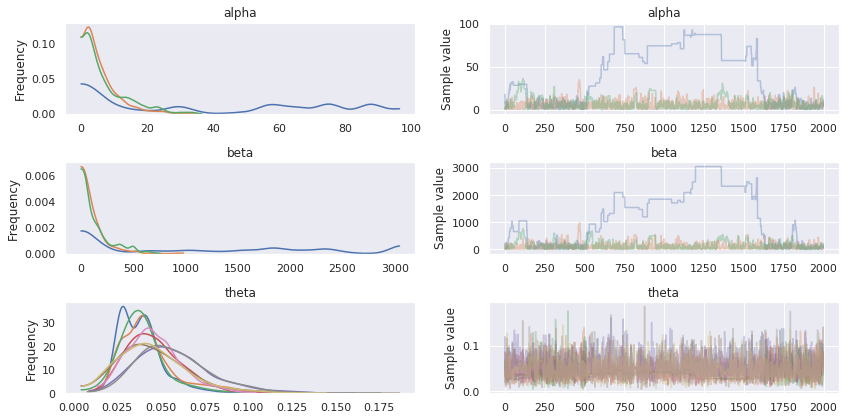

In [18]:
with pm.Model() as comparing_buyer_m2:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])
    
    trace_h2 = pm.sample(2000, chains=3, random_seed=100)
pm.traceplot(trace_h2)

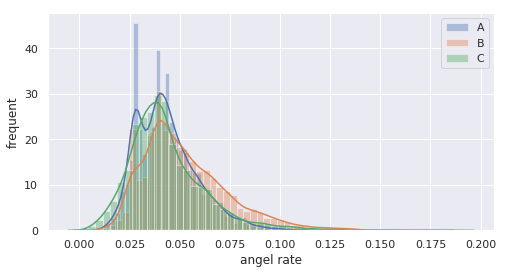

In [19]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_h2['theta'][:,i], label=buyer_cat[i], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_h2model.png')

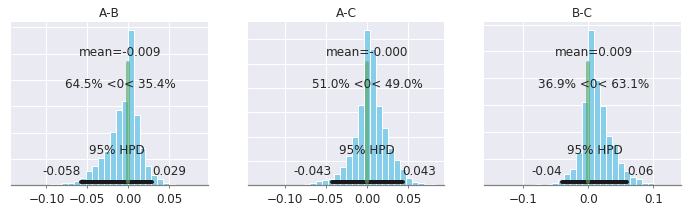

In [20]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, len(lst_buyer)), 2):
    theta_diff = trace_h2['theta'][:, i] - trace_h2['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_h2model.png')

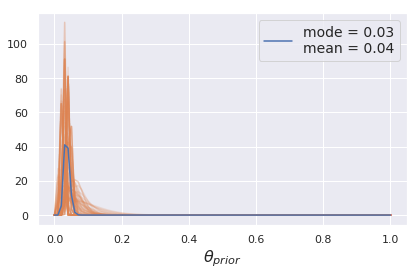

In [26]:
# thetaの事前分布
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h2), size=100):
    pdf = stats.beta(trace_h2['alpha'][i], trace_h2['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.beta(trace_h2['alpha'].mean(), trace_h2['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()
plt.savefig('buyer_effect_prior_h2model.png', dpi=300, figsize=(5.5, 5.5))
